In [44]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time, sys
from IPython.display import clear_output

In [47]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

### Gradient boosting Challenge

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

Lower the error rates, based on your model in the training set.

### From the Example and challenge

In [35]:
file = 'ESSdata_Thinkful.csv'
path = path="../../../../Datafiles/"
df = pd.read_csv((path+file)).dropna()

print("there are {} entries in the data file {}".format(len(df), file))

there are 8147 entries in the data file ESSdata_Thinkful.csv


In [36]:
df.head(5)

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


Columns used in the dataset: 

| Column Name | Definition | Status |
|-------------|--------------|-------|
|partner|Lives with partner: values 1 lives with partner, 2 does not.| Dependent|
|cntry|Country|Not used in model | Independent |
|idno|ID number| Not used in model | Independent |
|ppltrst|Most people can be trusted: 0 can't trust, 10 very trusing| Independent |
|pplfair|Most people try to take advantage of you| Independent |
|plhlp|Most of the time people are helpful| Independent |
|happy|How happy are you| Independent |
|sclmeet|How often do you socially meet with friends, relatives, colleagues| Independent |
|sclact|Take part in social activities| Independent |
|gndr|Gender| Independent |
|agea|Age of appliant| Independent |


In [37]:
# Let's add some new features...

df['partner'] = np.where(df['partner'] == 2, 0, 1) # Set it to 0=Nopartner, 1=partner
df['age55_happy'] = np.where(((df['agea'] >= 55) & (df['happy'] >=8)),1,0) # A new feature here

In [38]:
# Definine outcome and predictors.
print("the current time of start is {}".format(str(datetime.datetime.now())))

y = df['partner']
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
# X = df[['agea', 'pplhlp', 'happy', 'tvtot', 'pplfair', 'ppltrst', 'sclmeet','sclact','gndr']] # these were the most significant
# X = df.loc[:,  df.columns.isin(['agea', 'happy'])]
X = df[['agea','happy', 'sclmeet',  'tvtot', 'pplhlp', 'gndr', 'pplfair','ppltrst','sclact', 'age55_happy']] # added new feature age55_happy

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

#countries ,'ES', 'CH', 'CZ','NO','SE','DE'

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]
print("the current time of end is {}".format(str(datetime.datetime.now())))

the current time of start is 2019-05-23 12:53:08.328081
the current time of end is 2019-05-23 12:53:08.338923


In [39]:
X.head(20)

,agea,happy,sclmeet,tvtot,pplhlp,gndr,pplfair,ppltrst,sclact,age55_happy,CH,CZ,DE,ES,NO,SE
0,60.0,8.0,5.0,3.0,5.0,2.0,10.0,3.0,4.0,1,1,0,0,0,0,0
1,59.0,9.0,3.0,6.0,5.0,2.0,7.0,5.0,2.0,1,1,0,0,0,0,0
2,24.0,7.0,6.0,1.0,8.0,1.0,8.0,8.0,3.0,0,1,0,0,0,0,0
3,64.0,10.0,6.0,4.0,7.0,2.0,6.0,6.0,2.0,1,1,0,0,0,0,0
4,55.0,8.0,7.0,5.0,5.0,2.0,7.0,6.0,2.0,1,1,0,0,0,0,0
6,76.0,0.0,2.0,3.0,2.0,1.0,5.0,0.0,2.0,0,1,0,0,0,0,0
7,30.0,10.0,5.0,2.0,3.0,2.0,5.0,4.0,2.0,0,1,0,0,0,0,0
8,84.0,9.0,6.0,2.0,8.0,2.0,8.0,8.0,4.0,1,1,0,0,0,0,0
9,62.0,7.0,4.0,4.0,8.0,2.0,4.0,4.0,2.0,0,1,0,0,0,0,0
10,33.0,9.0,5.0,1.0,7.0,2.0,7.0,6.0,2.0,0,1,0,0,0,0,0


In [49]:
# We'll make 50 iterations, use 2-deep trees, and set our loss function.
lowest_train_tI_errors = (-1,1000)
lowest_train_tII_errors =(-1,1000)
lowest_test_tI_errors = (-1,1000)
lowest_test_tII_errors = (-1,1000)
min_value = 2
max_value = 100
loss_function = 'deviance'


print("\n{} We are testing with varying max_leaf_nodes and min_samples_leaf between {} and {},\nwith the loss_function={}.".format(str(datetime.datetime.now()),
                                                                                                                                   min_value, 
                                                                                                                                   max_value,
                                                                                                                                   loss_function))
tr_tI = 0
tr_tII = 0
te_tI = 0
te_tII = 0
for depth_value in range(2,max_value):
#     loss : {‘deviance’, ‘exponential’}, optional (default=’deviance’) 
#          from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    params = {'n_estimators': 500,
              'max_depth': 8,
              'loss': loss_function,
              'max_leaf_nodes': depth_value, # 8 worked best...
              'min_samples_leaf': depth_value * 3
             }

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    if pd.to_numeric(train_tI_errors) < lowest_train_tI_errors[1]:
        
        tr_tI = 1

    if pd.to_numeric(train_tII_errors) < lowest_train_tII_errors[1]:
        tr_tII = 1
    
    if tr_tI == 1 or tr_tII == 1:
        lowest_train_tI_errors = (depth_value,pd.to_numeric(train_tI_errors))
        lowest_train_tII_errors = (depth_value,pd.to_numeric(train_tII_errors))
        tr_tI = 0 
        tr_tII = 0
        
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    
    if pd.to_numeric(test_tI_errors) < lowest_test_tI_errors[1]:
        te_tI = 1
       
    if pd.to_numeric(test_tII_errors) < lowest_test_tII_errors[1]:
        te_tII = 1
    
    if te_tI == 1 or te_tII == 1:
        lowest_test_tI_errors = (depth_value,pd.to_numeric(test_tI_errors))
        lowest_test_tII_errors = (depth_value,pd.to_numeric(test_tII_errors))
        te_tI = 0
        te_tII = 0
    update_progress(depth_value / max_value)
update_progress(1)

# number_of_elements = 100
# for i in range(number_of_elements):
#     time.sleep(0.1) #Replace this with a real computation
#     update_progress(i / number_of_elements)
# update_progress(1)

# number_of_elements = 100
# for i in range(max_value):

#     update_progress(i / number_of_elements)
# update_progress(1)

print("\nHere are the summary findings.")
print("Lowest train_tI_Errors={}, found in max_leaf_nodes={}".format(lowest_train_tI_errors[1],
                                                                      lowest_train_tI_errors[0]))
print("Lowest train_tII_Errors={}, found in max_leaf_nodes={}".format(lowest_train_tII_errors[1],
                                                                      lowest_train_tII_errors[0]))

print("Lowest test_tI_Errors={}, found in max_leaf_nodes={}".format(lowest_test_tI_errors[1],
                                                                    lowest_test_tI_errors[0]))
print("Lowest test_tII_Errors={}, found in max_leaf_nodes={}".format(lowest_test_tII_errors[1],
                                                                     lowest_test_tII_errors[0]))
print("\n{} We finished testing at.".format(str(datetime.datetime.now())))

Progress: [####################] 100.0%

Here are the summary findings.
Lowest train_tI_Errors=0.08483360611020185, found in max_leaf_nodes=31
Lowest train_tII_Errors=0.01895799236224768, found in max_leaf_nodes=31
Lowest test_tI_Errors=0.18036809815950922, found in max_leaf_nodes=98
Lowest test_tII_Errors=0.09815950920245399, found in max_leaf_nodes=98

2019-05-23 15:35:13.822598 We finished testing at.


In [41]:
X.head(5)

,agea,happy,sclmeet,tvtot,pplhlp,gndr,pplfair,ppltrst,sclact,age55_happy,CH,CZ,DE,ES,NO,SE
0,60.0,8.0,5.0,3.0,5.0,2.0,10.0,3.0,4.0,1,1,0,0,0,0,0
1,59.0,9.0,3.0,6.0,5.0,2.0,7.0,5.0,2.0,1,1,0,0,0,0,0
2,24.0,7.0,6.0,1.0,8.0,1.0,8.0,8.0,3.0,0,1,0,0,0,0,0
3,64.0,10.0,6.0,4.0,7.0,2.0,6.0,6.0,2.0,1,1,0,0,0,0,0
4,55.0,8.0,7.0,5.0,5.0,2.0,7.0,6.0,2.0,1,1,0,0,0,0,0


In [42]:
def rfc_and_feature_importances(leaf_values):    # Here we are using Gradient Boosting classifier method to determine the top 30 features.
# train and then run RFC

    params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'max_leaf_nodes': leaf_values,
          'min_samples_leaf': leaf_values}
    
#     print("in rfc_and_feature_importanes, params={}".format(params))
    clf = ensemble.GradientBoostingClassifier(**params)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    ## Fit the model on your training data.
    clf.fit(X_train, y_train) 
    ## And score it on your testing data.
    clf.score(X_test, y_test)

    feature_importance = clf.feature_importances_

    # Make importances relative to max importance.
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    cols=X.columns[sorted_idx].tolist()
    cols=cols[::-1]
#     print("cols={}".format(cols))
#     print("sorted_idx = {}".format(X.columns[sorted_idx::-1]))
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    return cols # return it sorted

running rfc features for 10 times
params = 2


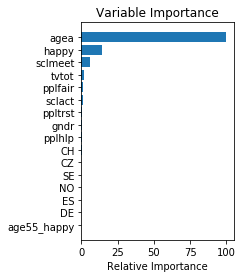

running rfc features for 10 times
params = 3


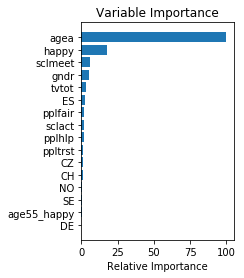

running rfc features for 10 times
params = 4


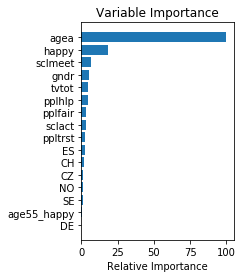

running rfc features for 10 times
params = 5


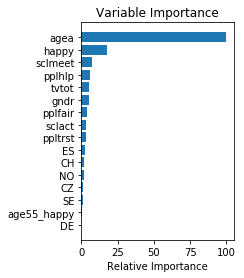

running rfc features for 10 times
params = 6


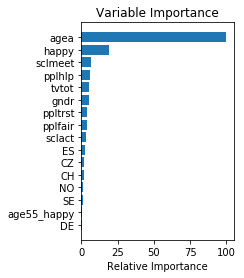

running rfc features for 10 times
params = 7


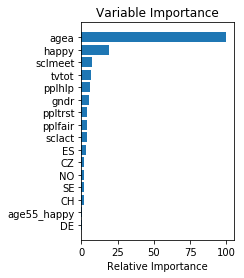

running rfc features for 10 times
params = 8


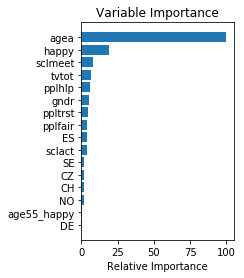

running rfc features for 10 times
params = 9


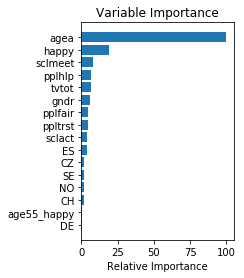

important_features: ['agea', 'happy', 'sclmeet', 'tvtot', 'pplfair', 'sclact', 'ppltrst', 'gndr', 'pplhlp', 'CH', 'CZ', 'SE', 'NO', 'ES', 'DE', 'age55_happy', '2']
important_features: ['agea', 'happy', 'sclmeet', 'gndr', 'tvtot', 'ES', 'pplfair', 'sclact', 'pplhlp', 'ppltrst', 'CZ', 'CH', 'NO', 'SE', 'age55_happy', 'DE', '3']
important_features: ['agea', 'happy', 'sclmeet', 'gndr', 'tvtot', 'pplhlp', 'pplfair', 'sclact', 'ppltrst', 'ES', 'CH', 'CZ', 'NO', 'SE', 'age55_happy', 'DE', '4']
important_features: ['agea', 'happy', 'sclmeet', 'pplhlp', 'tvtot', 'gndr', 'pplfair', 'sclact', 'ppltrst', 'ES', 'CH', 'NO', 'CZ', 'SE', 'age55_happy', 'DE', '5']
important_features: ['agea', 'happy', 'sclmeet', 'pplhlp', 'tvtot', 'gndr', 'ppltrst', 'pplfair', 'sclact', 'ES', 'CZ', 'CH', 'NO', 'SE', 'age55_happy', 'DE', '6']
important_features: ['agea', 'happy', 'sclmeet', 'tvtot', 'pplhlp', 'gndr', 'ppltrst', 'pplfair', 'sclact', 'ES', 'CZ', 'NO', 'SE', 'CH', 'age55_happy', 'DE', '7']
important_featur

In [43]:
max_items = 10
all_feature_important_columns = []

for i in range(2,max_items):
    print('running rfc features for {} times'.format(max_items))
    
    print("params = {}".format(i))
    columns2 = rfc_and_feature_importances(i)
    columns2.extend('{}'.format(i))
#     print("columns2 = {}".format(columns2))
    all_feature_important_columns.append(columns2)
#     print("all_feature_import_columns={}".format(all_feature_important_columns))
    
for list1 in all_feature_important_columns:
    print("important_features: {}".format(list1))